In [39]:
import os
import math
import cv2
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import transforms,datasets
import torch.optim as optim
from torch.autograd import Variable
import torchvision

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [40]:
torch.cuda.empty_cache()

In [41]:
apply_transform = transforms.ToTensor() # Any normalisation? of the pixel values?
BatchSize = 64

trainset = datasets.MNIST(root='./MNIST', train=True, download=True, transform=apply_transform)
trainLoader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=0) # Creating dataloader

# Validation set with random rotations in the range [-90,90]
testset = datasets.MNIST(root='./MNIST', train=False, download=True, transform=apply_transform)
testLoader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=0) # Creating dataloader
                                        

In [42]:
# Encoder Architecture #

class encoder(nn.Module): # Make sense of numbers
    def __init__(self):
        super(encoder, self).__init__()
        self.hidden_layer = nn.Linear(784,1000)
        self.output_layer = nn.Linear(1000,2)

    def forward(self, x):
        x = x.view(-1,784)
        x = F.relu(self.hidden_layer(x))
        x = F.relu(self.output_layer(x))

        return x
        
# Decoder Architecture #

class decoder(nn.Module): 
    def __init__(self):
        super(decoder, self).__init__()
        self.hidden_layer = nn.Linear(2,1000)
        self.output_layer = nn.Linear(1000,784)

    def forward(self, x):
        x = F.relu(self.hidden_layer(x))
        x = F.relu(self.output_layer(x))
        x = x.view(-1,1,28,28)
        return x

#Training 

The training scheme we follow is simple - we feed forward each minibatch of MNIST images and obtain an output. We compute the L2-norm of this output with the input, and then backpropagate to obtain the gradients, We then update the parameters of the model. 

We shall use Cosine Similarity to measure the similarity of the output with the input.

In [46]:
## Initialise the models
encode = encoder()
decode = decoder()

use_gpu = torch.cuda.is_available()

if use_gpu:
    print('GPU is avaialble!')
    encode = encode.cuda()
    decode = decode.cuda()

GPU is avaialble!


In [47]:
criterion_recon = nn.MSELoss()
similarity_recon = nn.CosineSimilarity()

learning_rate_AE = 0.001

opt_enc = optim.Adam(encode.parameters(),lr = learning_rate_AE) 
opt_dec = optim.Adam(decode.parameters(),lr = learning_rate_AE)

num_epochs = 50

train_loss = []
train_sim =[]

In [48]:
for epoch in range(num_epochs):
    running_loss = 0.0
    running_sim = 0.0
    for i,data in enumerate(trainLoader):
        inputs,ground = data
        if use_gpu:
            inputs,ground = inputs.cuda(),ground.cuda()
        opt_enc.zero_grad()
        opt_dec.zero_grad() 
        encode.train()
        decode.train()
        z = encode(inputs)
        out = decode(z)
        loss = criterion_recon(inputs, out) 
        running_loss += loss
        loss.backward()
        opt_enc.step()
        opt_dec.step()
        del z,out,loss
        torch.cuda.synchronize()
        # Calculating Reconstruction Accuracy
        running_sim += torch.sum(similarity_recon(inputs.view(-1,784),decode(encode(inputs)).view(-1,784)))
    epoch_loss = running_loss.item()/(i+1)   
    epoch_sim = running_sim.item()/60000
    train_loss.append(epoch_loss) 
    train_sim.append(epoch_sim)
    print('Epoch {:.0f}/{:.0f} : Reconstruction Training loss: {:.4f} | Train Similarity {:.4f}'.format(epoch+1,num_epochs,epoch_loss,epoch_sim))

Epoch 1/50 : Reconstruction Training loss: 0.0700 | Train Similarity 0.6114
Epoch 2/50 : Reconstruction Training loss: 0.0647 | Train Similarity 0.6517
Epoch 3/50 : Reconstruction Training loss: 0.0618 | Train Similarity 0.6723
Epoch 4/50 : Reconstruction Training loss: 0.0594 | Train Similarity 0.6884
Epoch 5/50 : Reconstruction Training loss: 0.0582 | Train Similarity 0.6964
Epoch 6/50 : Reconstruction Training loss: 0.0571 | Train Similarity 0.7037
Epoch 7/50 : Reconstruction Training loss: 0.0564 | Train Similarity 0.7082
Epoch 8/50 : Reconstruction Training loss: 0.0555 | Train Similarity 0.7140
Epoch 9/50 : Reconstruction Training loss: 0.0548 | Train Similarity 0.7184
Epoch 10/50 : Reconstruction Training loss: 0.0544 | Train Similarity 0.7212
Epoch 11/50 : Reconstruction Training loss: 0.0538 | Train Similarity 0.7247
Epoch 12/50 : Reconstruction Training loss: 0.0533 | Train Similarity 0.7277
Epoch 13/50 : Reconstruction Training loss: 0.0525 | Train Similarity 0.7324
Epoch 14

#Performance Evaluation

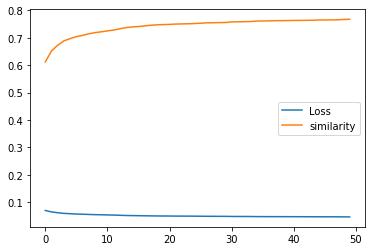

In [49]:
plt.plot(train_loss,label = 'Loss')
plt.plot(train_sim,label='similarity')
plt.legend()
plt.show()

In [50]:
### Function to normalize plots between 0 and 1 to visualise trends better ###
def normalise(X):
  X = np.array(X)
  max = np.max(X)
  min = np.min(X)
  X = (X-min)/(max-min)
  X = list(X)
  return X

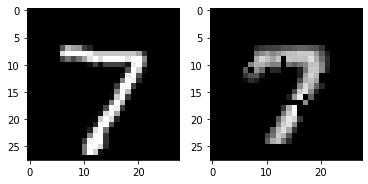

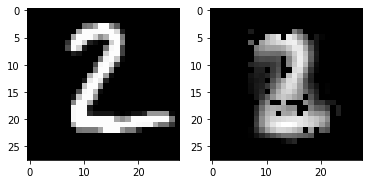

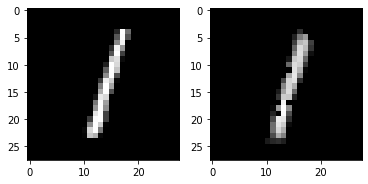

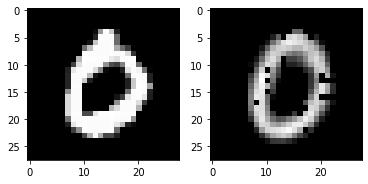

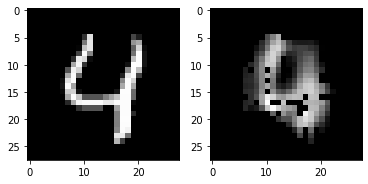

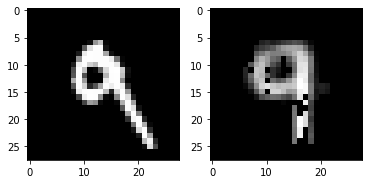

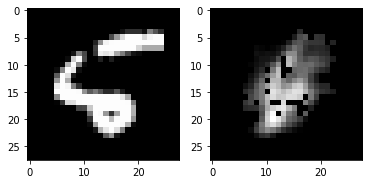

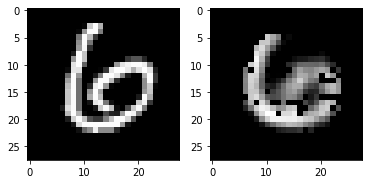

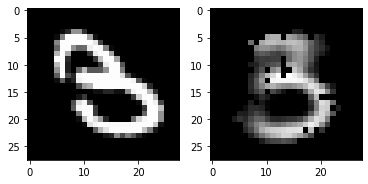

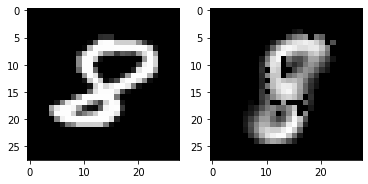

In [51]:
count = list(np.zeros(10))
#img_list = list(np.zeros(10))
c = 0
encode = encode.cpu()
decode = decode.cpu()
for i,data in enumerate(testLoader):
  image,label = data
  pred = decode(encode(image)).detach().numpy()
  if count[label] == 0:
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(np.reshape(image,(28,28)),cmap='gray')
    axarr[1].imshow(np.reshape(pred, (28,28)),cmap='gray')
    f.show()
    count[label]+=1
    c += 1
  
  if c == 10:
    break

As we can see above, with the exception of 5 and 8, the autoencoder correctly outputs the original handwritten number. Let us now treat the Decoder as a generative model and see what kind of outputs we shall obtain. Before that, let us first see the latent space distribution of the (training) dataset.  

# Decoder as Generator

## 1. Latent space distribution

In [52]:
LatentVectors = []
digits = []
images = []
for i,data in enumerate(trainLoader):
  inputs,ground = data
  z = encode(inputs)
  for j in z:
    LatentVectors.append(j.detach().numpy())
  for j in ground:
    digits.append(j.detach().numpy())
  for j in inputs:
    images.append(j.detach().numpy())

In [53]:
LatentVectors = np.array(LatentVectors)
digits = np.array(digits)

In [54]:
inds = digits.argsort()
sorted_digits = np.sort(digits)
LatentVectors_sorted = LatentVectors[inds]

In [55]:
x = []
y = []
for i in LatentVectors_sorted:
  x.append(i[0])
  y.append(i[1])

In [56]:
## Split the Array into digits ##
Split = [0]
for i in range(59999):
  if sorted_digits[i]  != sorted_digits[i+1]:
    Split.append(i+1)
Split.append(60000)
num_split = len(Split)

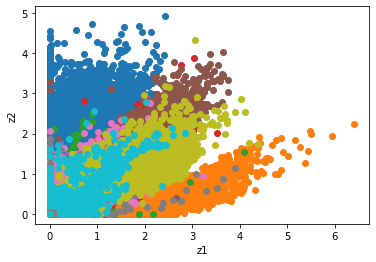

In [62]:
fig, ax = plt.subplots()
ax.set_xlabel('z1')
ax.set_ylabel('z2')
colours = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:gray','tab:olive','tab:cyan']
for i in range(num_split-1):
  ax.scatter(x[Split[i]:Split[i+1]],y[Split[i]:Split[i+1]],c = colours[sorted_digits[Split[i]]])

As we can see, the regions corresponding to various digits in the latent space are overlapping. This means that the autoencoder will not produce sharply defined images for points that fall in these overlap regions. One can also say that as we increase the number of dimensions of the latent space, we will observe more sharply defined regions for the various digits, and naturally the autoencoder will perform a better job. Additionally, we observe that beyond a certain region in this space, the sample points are sparsely distributed. We will now be inputing some sample latent space points from these regions to see how the autoencoder performs. Such values can be inferred from the plot of the latent space distribution

Q - Can one say that if we limit the sample space region (by fixing maximum amplitude of the latent vector) to some fixed radius, the sparsity will reduce and the autoencoder will perform better?

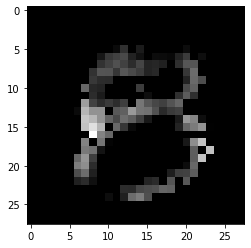

In [64]:
z1 = torch.from_numpy(np.array([6.0,4.0],dtype = np.double))
img = decode(z1.float())
img = np.reshape(img.detach().numpy(),(28,28))
plt.imshow(img,cmap = 'gray')

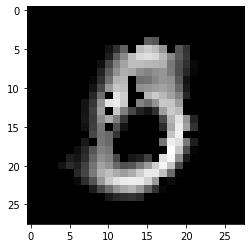

In [65]:
z1 = torch.from_numpy(np.array([1.3,2.0],dtype = np.double))
img = decode(z1.float())
img = np.reshape(img.detach().numpy(),(28,28))
plt.imshow(img,cmap = 'gray')

As we can see from the latent space graph, the point (1.3,2) is lying in the overlap of several colours. Thus, our output is also a 'combination' of all these digits. Let us now input a latent space vector from a clearly defined region - say (0.5,3.2). The output should resemble a '0', as this point lies clearly in the 'blue' region.

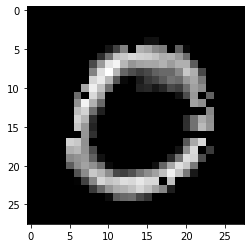

In [66]:
z1 = torch.from_numpy(np.array([0.5,3.2],dtype = np.double))
img = decode(z1.float())
img = np.reshape(img.detach().numpy(),(28,28))
plt.imshow(img,cmap = 'gray')